In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from statsmodels.graphics.gofplots import *
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
import joblib
from time import time

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

df = pd.read_csv("/content/drive/MyDrive/2. data/food.csv")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# the goal here is to convert to do things:
# 1 - convert the unique values per column to number system with mapping below
# 2 - make a new column with this new label encoded
le = LabelEncoder()

data_type_label = le.fit_transform(df['data_type'])
data_type_mappings = {index: label for index, label in enumerate(le.classes_)}
df['data_type_label'] = data_type_label

publication_date_label = le.fit_transform(df['publication_date'])
publication_date_mappings = {index: label for index, label in enumerate(le.classes_)}
df['publication_date_label'] = publication_date_label

print(data_type_mappings)
print(publication_date_mappings)
df.head()

# given the above, I should probably run a splitter function on the the description
# column and split by main name in the category

{0: 'agricultural_acquisition', 1: 'foundation_food', 2: 'market_acquisition', 3: 'sample_food', 4: 'sub_sample_food'}
{0: '2019-04-01', 1: '2019-12-16', 2: '2020-04-01', 3: '2020-10-30', 4: '2021-04-23', 5: '2021-04-28'}


,fdc_id,data_type,description,food_category_id,publication_date,data_type_label,publication_date_label
0,319874,sample_food,"HUMMUS, SABRA CLASSIC",16.0,2019-04-01,3,0
1,319875,market_acquisition,"HUMMUS, SABRA CLASSIC",16.0,2019-04-01,2,0
2,319876,market_acquisition,"HUMMUS, SABRA CLASSIC",16.0,2019-04-01,2,0
3,319877,sub_sample_food,Hummus,16.0,2019-04-01,4,0
4,319878,sub_sample_food,Hummus,16.0,2019-04-01,4,0


In [4]:
# let's make a new col for the description col by adding a simplified version that limits by ','
# first need to fill nulls with blanks
# remove case sensitivity
# split by comma and hyphen and stip spaces
df['simplified_description'] = df['description'].fillna('')
df['simplified_description'] = df['simplified_description'].str.lower()
df['simplified_description'] = df['simplified_description'].apply(lambda x: x.split(',')[0].split('-')[0].strip())
df['food_category_id_label'] = df['food_category_id'].fillna(df['food_category_id'].mean())


In [5]:
# now that we have a reasonable description list that is simplified, repeate step to make new col with new encoding
le = LabelEncoder()

description_label = le.fit_transform(df['simplified_description'])
description_mappings = {index: label for index, label in enumerate(le.classes_)}
df['description_label'] = description_label

print(description_mappings)

{0: '', 1: 'albertsons granulated sugar', 2: 'alexia', 3: 'almond milk', 4: 'almonds', 5: 'almonds dry roasted salted', 6: 'american cheese', 7: 'americas choice', 8: 'amino acids', 9: 'applebees', 10: 'apples', 11: 'b12', 12: 'bacon', 13: 'bacon; cooked', 14: 'bananas', 15: 'bartlett pears', 16: 'bay view farms', 17: 'beans', 18: 'beans snap canned drained', 19: 'beef', 20: 'beef breakfast sausage', 21: 'best choice sugar', 22: 'bread', 23: 'broccoli', 24: 'burger king', 25: 'butter', 26: 'c&h', 27: 'c&h granulated white sugar (ok1)', 28: 'canola oil', 29: 'cantaloupe', 30: 'carotenoids', 31: 'carrots', 32: 'cheddar cheese', 33: 'cheese', 34: 'cheese; american', 35: 'chick', 36: 'chick fil a', 37: 'chicken', 38: 'chicken breast', 39: 'chinese restaurant', 40: 'choles', 41: 'cholesterol', 42: 'cholesterol & moisture', 43: 'choline', 44: 'chorizo pork sausage', 45: 'cookies', 46: 'corn oil', 47: 'cottage cheese', 48: 'dennys', 49: 'dixie crystals', 50: 'domino sugar', 51: 'dried egg yol

In [6]:
converted_features = ['data_type_label', 'description_label', 'food_category_id_label', 'publication_date_label']

In [7]:
df_converted = df[converted_features]

In [8]:
df_converted.head()

,data_type_label,description_label,food_category_id_label,publication_date_label
0,3,89,16.0,0
1,2,89,16.0,0
2,2,89,16.0,0
3,4,89,16.0,0
4,4,89,16.0,0


In [9]:
df_converted.isnull().sum()

data_type_label           0
description_label         0
food_category_id_label    0
publication_date_label    0
dtype: int64

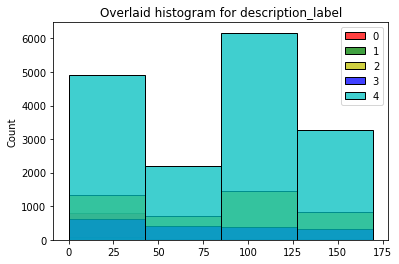

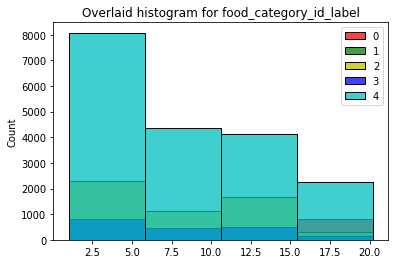

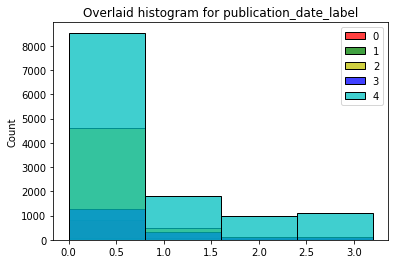

In [10]:
for i in ['description_label', 'food_category_id_label', 'publication_date_label']:
  
    agricultural_acquisition = list(df_converted[df_converted['data_type_label'] == 0][i].dropna())
    foundation_food = list(df_converted[df_converted['data_type_label'] == 1][i].dropna())
    market_acquisition = list(df_converted[df_converted['data_type_label'] == 2][i].dropna())
    sample_food = list(df_converted[df_converted['data_type_label'] == 3][i].dropna())
    sub_sample_food = list(df_converted[df_converted['data_type_label'] == 4][i].dropna())

    xmin = min(min(agricultural_acquisition), min(sub_sample_food))
    xmax = max(max(agricultural_acquisition), max(sub_sample_food))
    width = (xmax - xmin) / 5

    sns.histplot(agricultural_acquisition, color='r', kde=False, bins=np.arange(xmin, xmax, width))
    sns.histplot(foundation_food, color='g', kde=False, bins=np.arange(xmin, xmax, width))
    sns.histplot(market_acquisition, color='y', kde=False, bins=np.arange(xmin, xmax, width))
    sns.histplot(sample_food, color='b', kde=False, bins=np.arange(xmin, xmax, width))
    sns.histplot(sub_sample_food, color='c', kde=False, bins=np.arange(xmin, xmax, width))

    plt.legend(['0','1', '2', '3', '4'])
    plt.title('Overlaid histogram for {}'.format(i))
    plt.show()

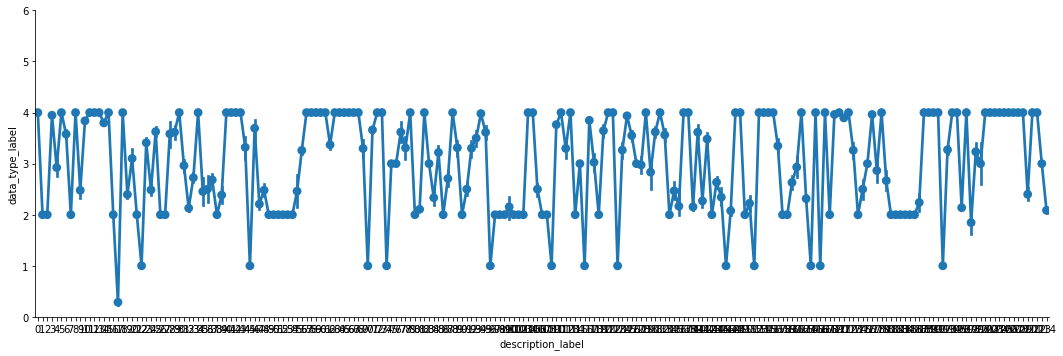

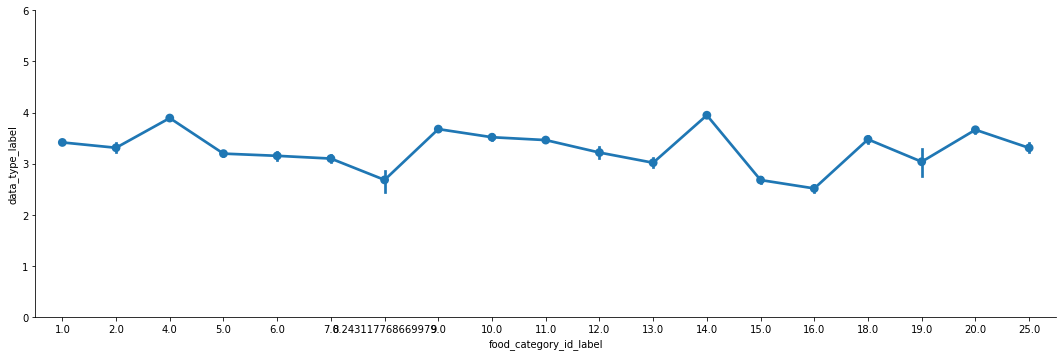

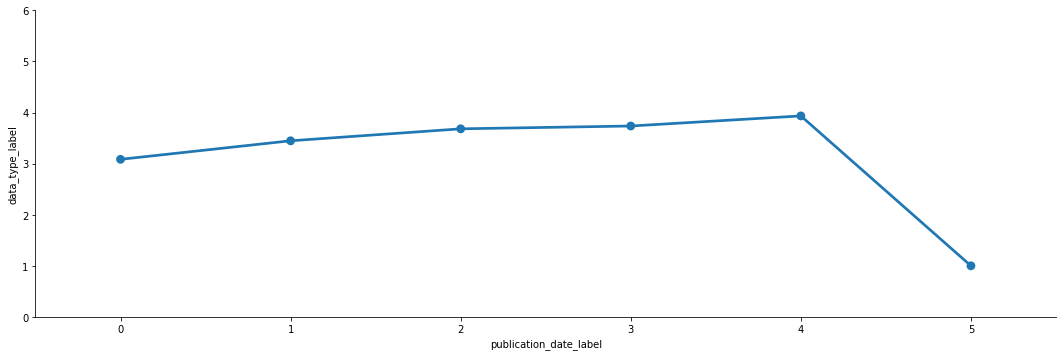

In [11]:
# plot the data
for col in ['description_label', 'food_category_id_label', 'publication_date_label']:
    sns.catplot(x=col, y='data_type_label', data=df_converted, kind='point', aspect=3, )
    plt.ylim(0, 6)